In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using MKLSparse
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using Plots
using ProgressMeter
using Random
ProgressMeter.ijulia_behavior(:clear)

false

In [2]:
Random.seed!(1)

TaskLocalRNG()

In [3]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [4]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [5]:
n_atoms = 4
bsys = tensor([bs for i in 1:n_atoms]...);

In [6]:
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]]);

In [7]:
H = Hamiltonian(H0)
H += 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H += -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [8]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)

trans = UnitaryTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [50]:
n_neurons = 4
sigmoid(x)= @. 40 / (1 + exp(-x))
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 2))
θ = initial_params(ann)  

n_params = length(θ)
Random.seed!(1)
θ = 2.0*rand(n_params).-1.0

t0, t1 = 0.0, 0.3

coeffs(params) = t->let vals = ann([t], params)
                        [abs(vals[1]), vals[2]]
                    end    

dr = ParametricDrive(Vector{Float64}(θ), coeffs, (t0, t1))
cost = CostFunction((x, y) -> x'*y,
                     p->2e-4 *(ann([t0], p)[1]^2+ ann([t1], p)[1]^2))

CostFunction(var"#107#109"(), var"#108#110"())

In [51]:
cost_bcs = CostFunction((x, y) -> x'*y,
                         p->2e-3 *(ann([t0], p)[1]^2+ ann([t1], p)[1]^2))
prob_bcs = QOCProblem(H, dr, trans, cost_bcs);

In [52]:
prob = QOCProblem(H, dr, trans, cost);

In [53]:
sol = QuantumOptimalControl.optimize(prob, ADAM(0.05), n_iter=500)

Progress: 100%|█████████████████████████████████████████| Time: 11:40:48
  cost:  0.8107522061049491


Solution{Float64}([-5.248987497288259, -3.3930222758712376, 5.266164907029034, -2.7919354719612426, 1.0285866430265116, 0.6603288295857608, -1.0388140825041652, 1.216611211360084, 9.965536472137163, -0.005562745661385761  …  -7.079735067368341, 10.749453508599723, 5.296269119491582, 2.3496666321022697, -4.720697866912267, -2.8509175822964394, -6.868168261072386, 11.770498341741888, -5.723608997445841, -3.093625242757048], [-0.003978115599253723, -0.0012766656622953312, -0.000150156453274837, -4.138077917406753e-5, -0.00036265178820206267, -0.0006077907194849176, -0.0006119099416485486, -0.0004606561704060175, -0.0002760227587657003, -0.00013139421855726106  …  0.8124415197182983, 0.8123674990739482, 0.8123022102163419, 0.8122196487053406, 0.8121487806096248, 0.812036946960085, 0.8119305662058329, 0.8117082159361102, 0.8114248895909125, 0.8107522061049491])

In [13]:
sol = QuantumOptimalControl.optimize(prob_bcs, ADAM(0.01), n_iter=3000)

Progress: 100%|█████████████████████████████████████████| Time: 0:21:05
  cost:  0.8068276810335674


Solution{Float64}([-9.051291105329502, 4.027971046710063, 2.4251088517471806, 7.747882003523611, 0.4202737750855481, -1.830314183292291, 3.828383722223758, -2.4334645103096952, -2.9152687430262567, -6.224305014692218  …  8.033111430180117, -4.281231780829958, -8.687763557003803, 0.2295727758629663, -0.5580784661212748, -16.111737132361654, -5.857153459129826, 3.4359868425162974, 8.267341576340316, 4.0158325878933185], [0.9485674496618272, 0.9436616848324, 0.9319680096653666, 0.9211149058610244, 0.9120228932949002, 0.9019710573586577, 0.8905448507864444, 0.8783054583096084, 0.86555469523603, 0.8525148821047103  …  0.8066969814072754, 0.8067109373868885, 0.8067254529294632, 0.8067396061795304, 0.8067542140140938, 0.8067684137828378, 0.8067831905108218, 0.8067978573655439, 0.8068128348004305, 0.8068276810335674])

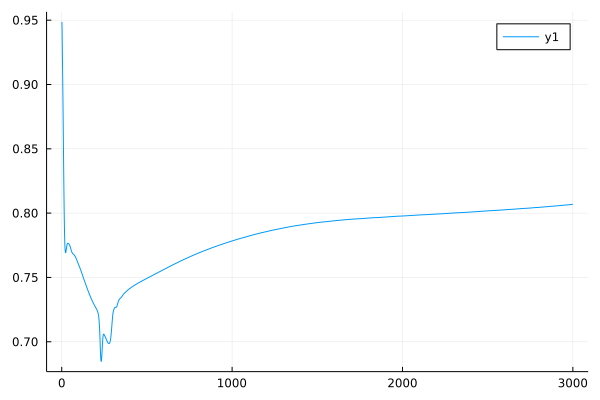

In [14]:
plot(sol.trace)

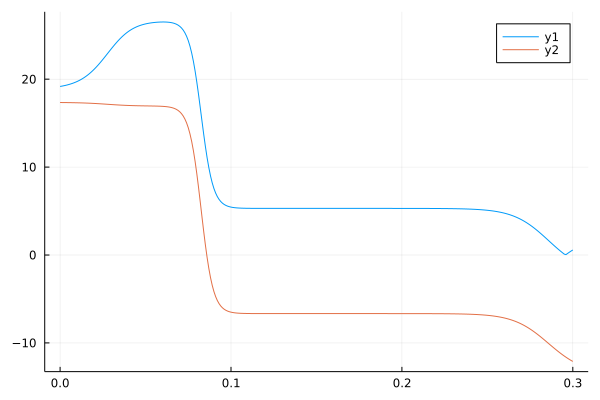

In [49]:
Ω(t) = let vals = ann([t], sol.params)
        abs(vals[1])
       end
Δ(t) = let vals = ann([t], sol.params)
        vals[2]
       end

ts = t0:0.001:t1
f = plot(ts, Ω.(ts))
plot!(f, ts, Δ.(ts))